# Basic case

In [1]:
import numpy as np
from numba import njit


def met_tmp(lat, T = 0.0):
    N = lat.shape[0]
    n = 0
    while n < N**2:
        i,j = np.random.randint(0, N, size=2)
        delta_E = get_delta_E(i,j,lat)
        if T ==0.0:
            if delta_E <=0:
                lat[i,j] *=-1
        else:
            w = np.exp(-delta_E / T)
            r = np.random.uniform(0.,1.)
            if w>r:
                lat[i,j] *= -1
        n += 1
    
    

@njit
def get_delta_E(i, j, lat):
    
    nx, ny = lat.shape  # Original number of points along each direction
    sp = lat[i, j]

    i_1 = (i-1)%nx
    i_2 = (i+1)%nx
    j_1 = (j + 1) % ny  # PBC y-dir
    j_2 = (j - 1) % ny # PBC y-dir
    
    sum_other = lat[i_1, j] + lat[i_2, j] + lat[i, j_1] + lat[i, j_2]

    return 2 * sp * sum_other  # Difference in energy when flipping


# Mon Jasnow 
---

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import palettable as pl
emr = pl.cartocolors.sequential.Emrld_7_r.get_mpl_colormap()

In [5]:
from mon_jasnow import ising_hamiltonian, metropolis_subroutine, metropolis_MJ
from lattice_utils import get_lattice_pp,get_lattice_pm, convert_pp_to_pm, energy_diff

In [67]:
N = 20
T = 0.1
%time la_pp = get_lattice_pp(N)
init_lattice = la_pp.copy()

Wall time: 0 ns


In [68]:
%%time
for _ in range(200): # N_sweeps
    metropolis_subroutine(la_pp, T, J=1)

Wall time: 37.9 ms


In [69]:
%time ising_hamiltonian(la_pp, J=1.0, boundary_cond='mj')
%time k =energy_diff(la_pp)
k

Wall time: 0 ns
Wall time: 0 ns


40

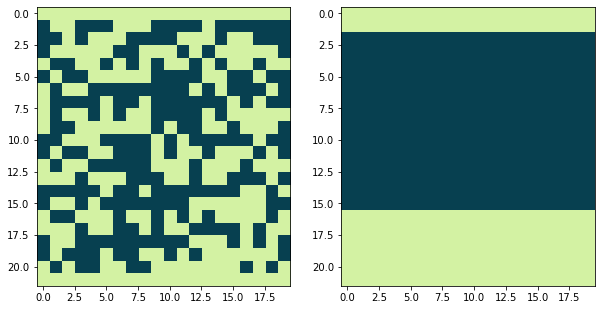

In [70]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(init_lattice, cmap=emr)
plt.subplot(122)
plt.imshow(la_pp, cmap=emr)

## Get energies

In [9]:
N_size= 32 # Size of arrays
N_avg = 20 # Number of elements average over
N_sweeps = 50 # Number of sweeps
T = 0.1
%time h_list = metropolis_MJ(N_size, N_sweeps, N_avg, T)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of Function(<built-in function array>) with argument(s) of type(s): (list(int64), size=UniTuple(array(int64, 2d, C) x 2))
 * parameterized
[1mIn definition 0:[0m
[1m    TypeError: typer() got an unexpected keyword argument 'size'[0m
    raised from C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\numba\typing\templates.py:283
[1mIn definition 1:[0m
[1m    TypeError: typer() got an unexpected keyword argument 'size'[0m
    raised from C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\numba\typing\templates.py:283
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: resolving callee type: Function(<built-in function array>)[0m
[0m[1m[2] During: typing of call at C:\Users\KarlKristian\Projects\NumFys\Exam\src\lattice_utils.py (30)
[0m
[1m
File "lattice_utils.py", line 30:[0m
[1mdef get_lattice_pm(N):
[1m    lattice = np.random.choice(np.array([-1, 1], size=(N + 2, N)))
[0m    [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function get_lattice_pm at 0x00000250A963F318>))[0m
[0m[1m[2] During: typing of call at C:\Users\KarlKristian\Projects\NumFys\Exam\src\mon_jasnow.py (151)
[0m
[0m[1m[3] During: resolving callee type: type(CPUDispatcher(<function get_lattice_pm at 0x00000250A963F318>))[0m
[0m[1m[4] During: typing of call at C:\Users\KarlKristian\Projects\NumFys\Exam\src\mon_jasnow.py (151)
[0m
[1m
File "mon_jasnow.py", line 151:[0m
[1mdef metropolis_MJ(N_size, N_sweeps, N_avg, T):
    <source elided>

[1m        lattice_pm = get_lattice_pm(lattice_pp)
[0m        [1m^[0m[0m


In [11]:
m = np.array([np.exp(-(h[1]-h[0])/(N_size**2 * T)) for h in h_list]).mean()
-T * np.log(m) * N_size

NameError: name 'h_list' is not defined

In [71]:
Tc = 2/np.log(1+np.sqrt(2)) # critical temperature

In [5]:
T_list = np.linspace(0.001,2*Tc, 10)

NameError: name 'np' is not defined

In [14]:
from dask import delayed, compute

In [15]:
%%time
tau_list = np.zeros_like(T_list)
h =[]
for t in T_list:
    h_list = delayed(metropolis_MJ)(N_size, N_sweeps, N_avg, t)
    h.append(h_list)
    
res = compute(*h)

for i,t in enumerate(T_list):
    p = np.array([np.exp(-(h[1]-h[0])/(N_size**2 * t))*np.exp(-h[0]/(N_size**2 * t)) for h in res[i]])
    zp = np.array([np.exp(-h[0] / (N_size**2 * t)) for h in res[i]])
    partition_ratio  = np.sum(p) / np.sum(zp)
    tau_list[i] = -t * np.log(partition_ratio)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mInvalid use of Function(<built-in function array>) with argument(s) of type(s): (list(int64), size=UniTuple(array(int64, 2d, C) x 2))
 * parameterized
[1mIn definition 0:[0m
[1m    TypeError: typer() got an unexpected keyword argument 'size'[0m
    raised from C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\numba\typing\templates.py:283
[1mIn definition 1:[0m
[1m    TypeError: typer() got an unexpected keyword argument 'size'[0m
    raised from C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\numba\typing\templates.py:283
[1mThis error is usually caused by passing an argument of a type that is unsupported by the named function.[0m[0m
[0m[1m[1] During: resolving callee type: Function(<built-in function array>)[0m
[0m[1m[2] During: typing of call at C:\Users\KarlKristian\Projects\NumFys\Exam\src\lattice_utils.py (30)
[0m
[1m
File "lattice_utils.py", line 30:[0m
[1mdef get_lattice_pm(N):
[1m    lattice = np.random.choice(np.array([-1, 1], size=(N + 2, N)))
[0m    [1m^[0m[0m

[0m[1m[1] During: resolving callee type: type(CPUDispatcher(<function get_lattice_pm at 0x00000250A963F318>))[0m
[0m[1m[2] During: typing of call at C:\Users\KarlKristian\Projects\NumFys\Exam\src\mon_jasnow.py (151)
[0m
[0m[1m[3] During: resolving callee type: type(CPUDispatcher(<function get_lattice_pm at 0x00000250A963F318>))[0m
[0m[1m[4] During: typing of call at C:\Users\KarlKristian\Projects\NumFys\Exam\src\mon_jasnow.py (151)
[0m
[1m
File "mon_jasnow.py", line 151:[0m
[1mdef metropolis_MJ(N_size, N_sweeps, N_avg, T):
    <source elided>

[1m        lattice_pm = get_lattice_pm(lattice_pp)
[0m        [1m^[0m[0m


In [16]:
test_h = res[0][0]
e1 =np.exp(-(test_h[1]-test_h[0])/(N_size**2 * T_list[0])) 
e2 = np.exp(-test_h[0]/(N_size**2 * 0.001))
print(e1, e2)

NameError: name 'res' is not defined

In [72]:
@njit
def alternative_metropolis_mj(N_size, N_sweeps, T, skips = 50, N_runs = 10):
    ev = []
    for run in range(N_runs):
        lattice_pp = get_lattice_pp(N_size)                         # Create ++ -lattice
#         lattice_pm = get_lattice_pm(N_size)
        prev = 0                                                    # keeps track of last sampled state 
        for i in range(N_sweeps):                                   # Do N_sweep sweeps
            metropolis_subroutine(lattice_pp, T, J=1.0)              # Tries to flip N^2 spins
#             metropolis_subroutine(lattice_pm, T, J=1.0)
            if (i > 50) and (i>=(prev+skips)):                      # Initial sweeps, and skip sweep between each sample
                prev = i
#                 lattice_pm  = convert_pp_to_pm(lattice_pp)
#                 lattice_pm = get_lattice_pm(lattice_pp)             # Create (+-) - lattice
#                 E_pp = ising_hamiltonian(lattice_pp)                # Get energies
#                 E_pm = ising_hamiltonian(lattice_pm)
                E_diff = energy_diff(lattice_pp)
                ev.append(np.exp(-(E_diff) / (T)))     # Add exp(-(E_{+-} - E_{++})/T) to a list
    ev = np.array(ev)
    return ev.mean(), ev.std()                                  # Return the mean and std

In [73]:
N_size=  16
N_sweeps = 2000
T = 0.1 
%time ev,_ = alternative_metropolis_mj(N_size, N_sweeps, T, skips=2)
-T*np.log(ev)

Wall time: 3.64 s


31.99999999999999

In [74]:
t = np.linspace(0.01, 4, 30)

In [75]:
%time tau = np.array([t_ * np.log(alternative_metropolis_mj(N_size, N_sweeps, t_)) for t_ in t])

C:\Users\KarlKristian\Anaconda3\envs\numfys\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Wall time: 1min 10s


Text(0, 0.5, '$\\tau$')

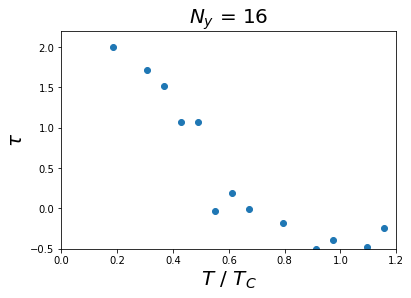

In [76]:
plt.scatter(t/Tc, -tau[:,0]/N_size)
# plt.fill_between(t/Tc, -e, -(e+s), alpha = 0.2)
# plt.fill_between(t/Tc, -e, (-e+s), alpha=  0.2)
plt.xlim(0,1.2)
plt.ylim(-0.5,2.2)
plt.xlabel(fr"$T\ /\ T_C$", size=20)
plt.title(f"$N_y$ = {N_size}", size=20)
plt.ylabel(fr"$\tau$", size = 20)

### Fig 4

In [47]:
N_list = np.arange(2, 32)

In [48]:
tau_f = np.array([-Tc * np.log(alternative_metropolis_mj(n, N_sweeps, Tc)[0]) for n in N_list])

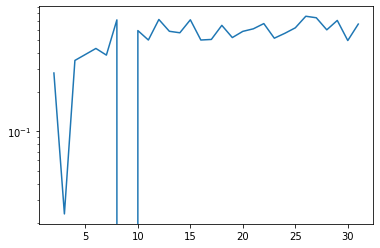

In [53]:
plt.semilogy(N_list, tau_f)

In [89]:
ising_hamiltonian(la_pm) - ising_hamiltonian(la_pp)

40.0